<a href="https://colab.research.google.com/github/Torikul385/ComputerVision/blob/main/image_captioning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import efficientnet


import re
import string
import time
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip


In [4]:
captions_path = 'Flickr8k.token.txt'
dataset_path = 'Flicker8k_Dataset'

In [5]:
!head -10 Flickr8k.token.txt

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


There are maximum 5 captions per image

In [6]:
IMAGES_PATH = 'Flicker8k_Dataset'
IMAGE_SIZE = (299,299)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
BATCH_SIZE = 32
FF_DIM = 512
EMBED_DIM = 512
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def read_captions(filename):

    with open(filename, "r") as f:
        lines = f.readlines()


    caption_mapping = {}
    images_to_skip = set()
    text_data = []

    for line in lines:
        line = line.rstrip("\n")
        line = line.strip().split("\t")
        imagepath = line[0].split('#')[0]
        imagepath = os.path.join(IMAGES_PATH, imagepath.strip())
        caption = line[1]

        tokens = caption.strip().split()

        if len(tokens)<5 or len(tokens) > SEQ_LENGTH:
            images_to_skip.add(imagepath)
            continue

        if imagepath.endswith("jpg") and imagepath not in images_to_skip:
            caption = "<start> " + caption.strip() + " <end>"
            text_data.append(caption)

            if imagepath not in caption_mapping:
                caption_mapping[imagepath] = [caption]
            else:
                caption_mapping[imagepath].append(caption)

    for img_name in images_to_skip:
        if img_name in caption_mapping:
            caption_mapping.pop(img_name)

    return caption_mapping, text_data

In [8]:
caption_map, text_data = read_captions(captions_path)

strip_chars = string.punctuation
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">",  "")

def custom_standardization(input_string):
    lower = tf.strings.lower(input_string)
    stripped = tf.strings.regex_replace(lower, "[%s]" % re.escape(strip_chars), "")
    return tf.strings.strip(stripped)


vectorization_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
)

vectorization_layer.adapt(text_data)

In [9]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):

    all_images = list(caption_data.keys())

    if shuffle:
        np.random.shuffle(all_images)

    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name : caption_data[img_name] for img_name in all_images[:train_size]
    }

    validation_data = {
        img_name : caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data


In [15]:
train_data , val_data = train_val_split(caption_map)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image


def preprocess_data(img_path, text):
    img = load_image(img_path)
    text = vectorization_layer(text)
    return img, text

def make_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((list(data.keys()), list(data.values())))
    dataset = dataset.map(preprocess_data)
    dataset = dataset.shuffle(len(data)).batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset




train_ds = make_dataset(train_data)
val_ds = make_dataset(val_data)

In [16]:
imgs, captions = next(iter(train_ds))

print(imgs.shape, captions.shape)

(32, 299, 299, 3) (32, 5, 25)


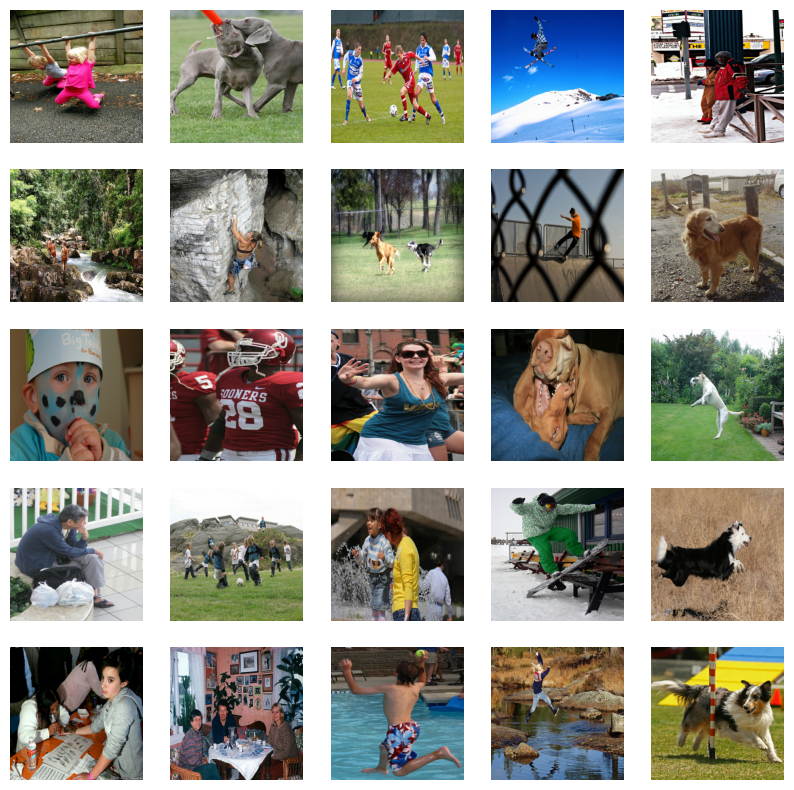

In [19]:
plt.figure(figsize=(10,10))

for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(imgs[i])
    plt.axis("off")


In [20]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )

    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(inputs=base_model.input, outputs=base_model_out)
    return cnn_model

In [29]:
# cnn_model
cnn_model = get_cnn_model()
cnn_model.output

<KerasTensor shape=(None, 100, 1280), dtype=float32, sparse=False, name=keras_tensor_479>

In [43]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout =0
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense = layers.Dense(dense_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense(inputs)
        x = self.attention_1(inputs, inputs, inputs, attention_mask=mask, training=training)
        out = self.layernorm_2(inputs + x)
        return out




class PositionalEmbedding(layers.Layer):
    def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_embed = layers.Embedding(input_dim=vocab_size, output_dim = embed_dim)
        self.position_embed = layers.Embedding(input_dim=seq_length, output_dim = embed_dim)

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_length = seq_length

        self.scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit = length, delta=1)
        embedded_tokens = self.token_embed(inputs) * self.scale
        embedded_positions = self.position_embed(positions)
        return embedded_tokens + embedded_positions


In [44]:
#checking encoder
encoder = TransformerEncoder(512,512, num_heads = 1)
x = tf.random.uniform((32,100,1280))
encoder(x, training=False).shape

TensorShape([32, 100, 512])

In [28]:
#checking positional encoder
pos_embedding = PositionalEmbedding(25, 10000, 512)
x = tf.cast(np.random.randint(10000, size=(5,25)), tf.int32)
pos_embedding(x).shape

TensorShape([5, 25, 512])

In [68]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            seq_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        #mask = tf.linalg.band_part(tf.ones((input_shape[1], input_shape[1]), dtype=tf.int32), -1, 0)
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


In [64]:
tf.linalg.band_part(tf.ones((3, 3)), -1, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [53]:
np.tril(np.ones((3,3)), k=0)

array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]])

In [69]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoder(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=None,
)

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

EPOCHS = 2
# Number of training steps
num_train_steps = len(train_ds) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping],
)


Epoch 1/2
